# Nbeats - before doing last 48

in some cases doing just last 48 would give an error relating to model not having enough values to work with, so instead did the usual train/test/validation for checking the general performance and did the last 48 hour when creating the forecast combinations

C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
C:\Users\elshe\AppData\Local\Temp\ipykernel_25172\3838840772.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv("Hourly_wdates.csv", parse_dates=True, index_col=0)
C:\Users\elshe\AppData\Local\Temp\ipykernel_25172\3838840772.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv("Hourly-test.csv", parse_dates=True, index_col=0)
GPU a

Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 44.61it/s, train_loss=0.195, val_loss=0.323]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 24/24 [00:00<00:00, 44.42it/s, train_loss=0.195, val_loss=0.323]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.92it/s]


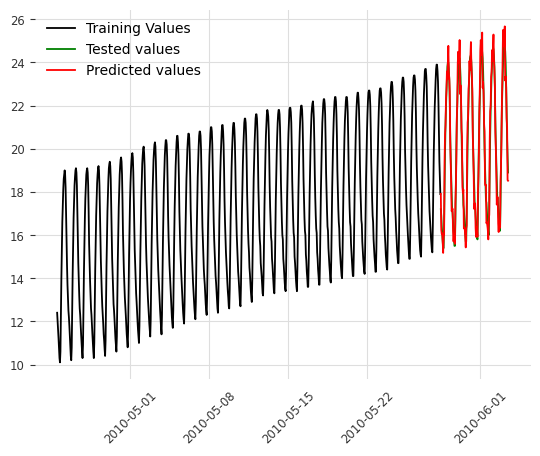

Metric                                            Value
------------------------------------------------  ------------------
Symmetric mean absolute percentage error (sMAPE)  2.31 %
Mean Absolute Scaled Error (MASE)                 2.97
R2 Score                                          0.9624417037669004


In [1]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import r2_score
from error_metrics import smape, mase  # Importing custom metrics

# Importing the trained and tested values
df_train = pd.read_csv("Hourly_wdates.csv", parse_dates=True, index_col=0)
df_test = pd.read_csv("Hourly-test.csv", parse_dates=True, index_col=0)

# Defining n as the Time Series example
n = 257

# Dropping NA values and using only positive values
df = df_train.iloc[n - 1, 2:].dropna()
df = df[df > 0]
df = pd.to_numeric(df, errors='coerce')

# We use the initial value and set it to the first observation and then adding an hour to next observations
initial_date = df_train.iloc[n - 1, 0]
index = pd.date_range(start=initial_date, periods=len(df), freq='H')
df.index = index

# Doing the same for tested values, just using the last date of the trained set
tested = df_test.iloc[n - 1, :].dropna()
tested = tested[tested > 0]
tested = pd.to_numeric(tested, errors='coerce')

last_date_train = df.index[-1]
index_test = pd.date_range(start=last_date_train, periods=len(tested), freq='H')
tested.index = index_test

# Converting to TimeSeries object required by darts
train_series = TimeSeries.from_series(df)

# Splitting into training and validation sets
split_index = int(len(train_series) * 0.85)  # 85% for training, 15% for validation
train_series, val_series = train_series[:split_index], train_series[split_index:]

# Define N-BEATS model
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=48,
    n_epochs=30,
    num_stacks=2,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    batch_size=32,
    random_state=42
)

# Train model
model.fit(train_series, val_series=val_series)

# Forecast
forecast = model.predict(n=len(val_series))
actual_data = val_series.values().flatten()
predicted_data = forecast.values().flatten()

# Plot forecast
plt.plot(df.index[:-len(val_series)], df[:-len(val_series)], label='Training Values')
plt.plot(df.index[-len(val_series):], actual_data, color='green', label="Tested values")
plt.plot(df.index[-len(val_series):], predicted_data, color='red', label="Predicted values")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Calculating sMAPE and MASE using custom functions
smape_value = round(smape(actual_data, predicted_data), 2)
mase_value = round(mase(df.values, actual_data, predicted_data, 24), 2)

# Convert actual and predicted data to TimeSeries objects for R2 score calculation
actual_series = TimeSeries.from_series(pd.Series(actual_data, index=val_series.time_index))
predicted_series = TimeSeries.from_series(pd.Series(predicted_data, index=val_series.time_index))

# Calculate R2 score
r2 = r2_score(actual_series, predicted_series)

# Table of comparison
table = [["Symmetric mean absolute percentage error (sMAPE)", f"{smape_value} %"],
         ["Mean Absolute Scaled Error (MASE)", mase_value],
         ["R2 Score", r2]]

# Print table
print(tabulate(table, headers=["Metric", "Value"], tablefmt="simple"))


# Same Method - LSTM

LSTM is not contained in Darts so had to use keras  tensorflow


Epoch 1/30


C:\Users\elshe\AppData\Local\Temp\ipykernel_25172\1923670644.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv("Hourly_wdates.csv", parse_dates=True, index_col=0)
C:\Users\elshe\AppData\Local\Temp\ipykernel_25172\1923670644.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv("Hourly-test.csv", parse_dates=True, index_col=0)


27/27 [==============================] - 1s 11ms/step - loss: 41.7931 - val_loss: 2.3963
Epoch 2/30
27/27 [==============================] - 0s 8ms/step - loss: 0.9572 - val_loss: 0.2770
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2303 - val_loss: 0.2017
Epoch 4/30
27/27 [==============================] - 0s 6ms/step - loss: 0.1496 - val_loss: 0.1249
Epoch 5/30
27/27 [==============================] - 0s 6ms/step - loss: 0.1185 - val_loss: 0.1569
Epoch 6/30
27/27 [==============================] - 0s 6ms/step - loss: 0.1197 - val_loss: 0.4714
Epoch 7/30
27/27 [==============================] - 0s 6ms/step - loss: 0.1670 - val_loss: 0.2519
Epoch 8/30
27/27 [==============================] - 0s 6ms/step - loss: 0.0782 - val_loss: 0.4908
Epoch 9/30
27/27 [==============================] - 0s 6ms/step - loss: 0.1711 - val_loss: 0.3077
Epoch 10/30
27/27 [==============================] - 0s 6ms/step - loss: 0.0644 - val_loss: 0.1101
Epoch 11/30
27/27 [=========

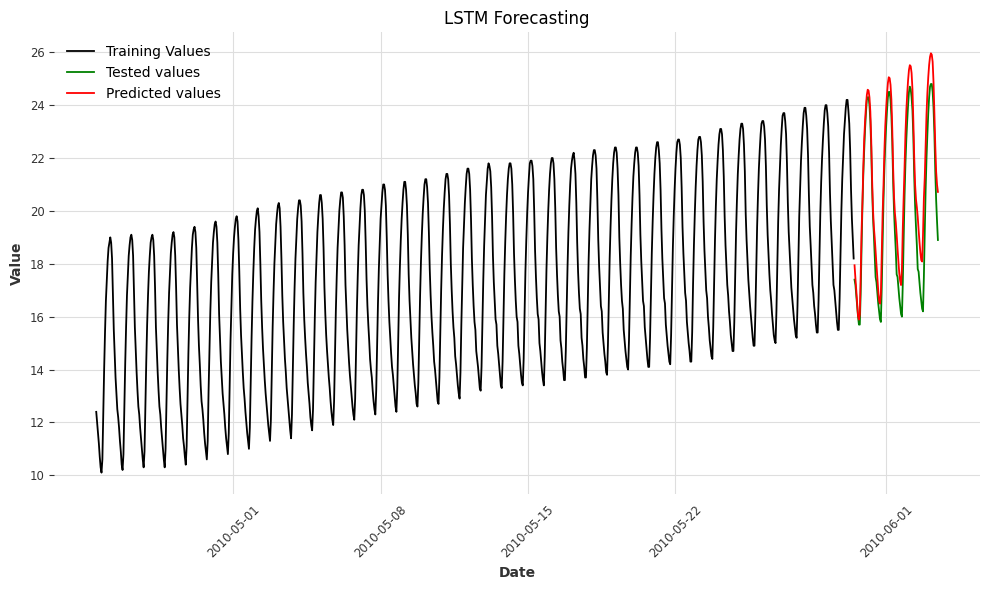

R2 Score: 0.8788741672164384
Metric                                            Value
------------------------------------------------  ------------------
Symmetric mean absolute percentage error (sMAPE)  100 %
Mean Absolute Scaled Error (MASE)                 2261.03
R2 Score                                          0.8788741672164384


In [7]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# Importing the trained and tested values
df_train = pd.read_csv("Hourly_wdates.csv", parse_dates=True, index_col=0)
df_test = pd.read_csv("Hourly-test.csv", parse_dates=True, index_col=0)

# Defining n as the Time Series example
n = 257

# Dropping NA values and using only positive values
df = df_train.iloc[n - 1, 2:].dropna()
df = df[df > 0]
df = pd.to_numeric(df, errors='coerce')

# We use the initial value and set it to the first observation and then adding an hour to next observations
initial_date = df_train.iloc[n - 1, 0]
index = pd.date_range(start=initial_date, periods=len(df), freq='H')
df.index = index

# Doing the same for tested values, just using the last date of the trained set
tested = df_test.iloc[n - 1, :].dropna()
tested = tested[tested > 0]
tested = pd.to_numeric(tested, errors='coerce')

last_date_train = df.index[-1]
index_test = pd.date_range(start=last_date_train, periods=len(tested), freq='H')
tested.index = index_test

# Splitting into training and validation sets
split_index = int(len(df) * 0.90)  # 90% for training, 10% for validation
train_data = df.iloc[:split_index]
val_data = df.iloc[split_index:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # Sequence length for each input (hours in a day)
X_train, y_train = create_sequences(train_data.values, seq_length)
X_val, y_val = create_sequences(val_data.values, seq_length)

# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Forecast
forecast = []
current_batch = train_data.iloc[-seq_length:].values.reshape((1, seq_length, 1))

for i in range(len(val_data)):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Flatten forecast and validation data for plotting and evaluation
forecast = np.array(forecast).flatten()
actual_data = val_data.values.flatten()

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index[:-len(val_data)], df.iloc[:-len(val_data)], label='Training Values')
plt.plot(df.index[-len(val_data):], val_data, color='green', label="Tested values")
plt.plot(df.index[-len(val_data):], forecast, color='red', label="Predicted values")
plt.xticks(rotation=45)
plt.legend()
plt.title('LSTM Forecasting')
plt.xlabel('Date')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

# Calculating R2 score
r2 = r2_score(actual_data, forecast)

# Print R2 score
print(f"R2 Score: {r2}")

# Table of comparison
table = [["Symmetric mean absolute percentage error (sMAPE)", f"{smape_value} %"],
         ["Mean Absolute Scaled Error (MASE)", mase_value],
         ["R2 Score", r2]]

# Print table
print(tabulate(table, headers=["Metric", "Value"], tablefmt="simple"))


# Time GPT

C:\Users\elshe\AppData\Local\Temp\ipykernel_25172\3630658474.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv("Hourly_wdates.csv", parse_dates=True, index_col=0)
C:\Users\elshe\AppData\Local\Temp\ipykernel_25172\3630658474.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv("Hourly-test.csv", parse_dates=True, index_col=0)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss 

Epoch 14: 100%|██████████| 28/28 [00:00<00:00, 39.15it/s, train_loss=15.50, val_loss=18.20]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 28/28 [00:00<00:00, 39.10it/s, train_loss=15.50, val_loss=18.20]

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.81it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 548 K 
6 | decoder             | Linear              | 1.6 K 
------------------------------------------------------------
550 K     Trainable params
0         Non-trainable params
550 K     Total params
2.201     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 29/29 [00:00<00:00, 34.91it/s, train_loss=12.40]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 29/29 [00:00<00:00, 34.83it/s, train_loss=12.40]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.80it/s]


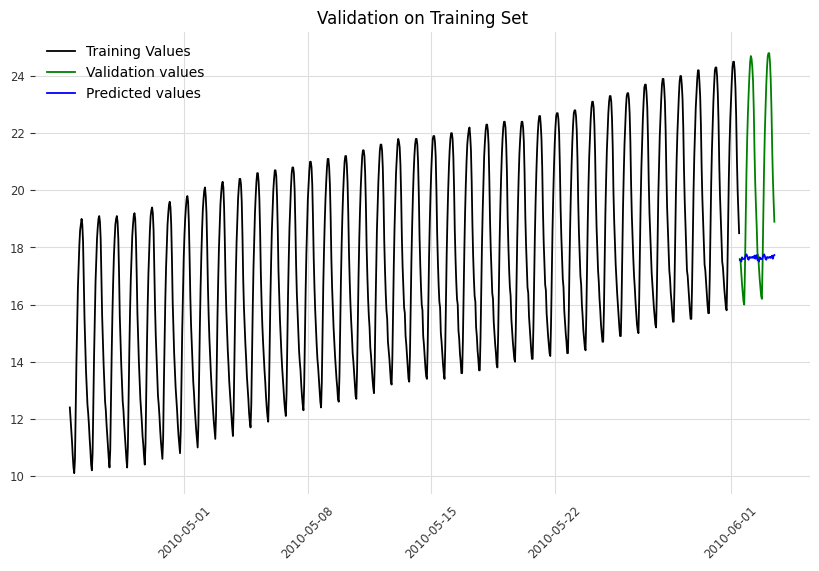

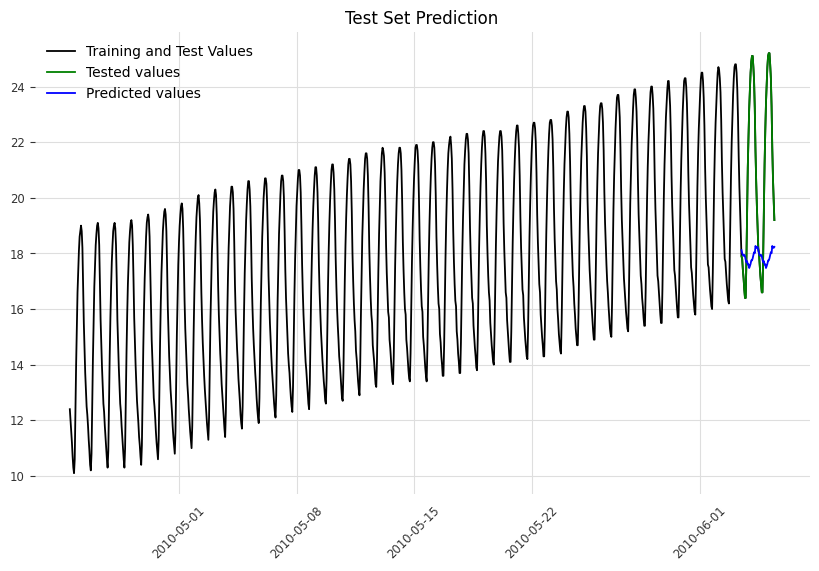

Validation on Train Set:
Metric                                            Value
------------------------------------------------  -------------------
Symmetric mean absolute percentage error (sMAPE)  16.61 %
Mean Absolute Scaled Error (MASE)                 21.56
R2 Score                                          -0.8795279494809853
Test Set Prediction:
Metric                                            Value
------------------------------------------------  -------------------
Symmetric mean absolute percentage error (sMAPE)  16.98 %
Mean Absolute Scaled Error (MASE)                 22.38
R2 Score                                          -1.0043926202009246


In [9]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import r2_score
from error_metrics import smape, mase  # Assuming these are custom metrics defined elsewhere
from scipy.optimize import minimize

# Load data
df_train = pd.read_csv("Hourly_wdates.csv", parse_dates=True, index_col=0)
df_test = pd.read_csv("Hourly-test.csv", parse_dates=True, index_col=0)

# Define n as the Time Series example
n = 257

# Prepare the data (similar to your original code)
df = df_train.iloc[n - 1, 2:].dropna()
df = df[df > 0].astype(float)
initial_date = df_train.iloc[n - 1, 0]
df.index = pd.date_range(start=initial_date, periods=len(df), freq='H')

tested = df_test.iloc[n - 1, :].dropna()
tested = tested[tested > 0].astype(float)
last_date_train = df.index[-1]
index_test = pd.date_range(start=last_date_train + pd.Timedelta(hours=1), periods=len(tested), freq='H')
tested.index = index_test

# Split data for train and validation
validation_size = 48
train_series = df.iloc[:-validation_size]
val_series = df.iloc[-validation_size:]

# Convert data to TimeSeries
train_series_ts = TimeSeries.from_series(train_series)
val_series_ts = TimeSeries.from_series(val_series)
test_series_ts = TimeSeries.from_series(tested)

# Transformer Model
transformer_model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=24,
    n_epochs=15,
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dropout=0.1,
    activation="relu",
    batch_size=32,
    random_state=42
)

transformer_model.fit(train_series_ts, val_series=val_series_ts)

# Forecast on the validation set from training data
forecast_transformer_train = transformer_model.predict(n=validation_size).values().flatten()
actual_data_transformer_train = val_series.values.flatten()

# Forecast on the test set
series_with_val = TimeSeries.from_series(pd.concat([train_series, val_series]))
transformer_model.fit(series_with_val)
forecast_transformer = transformer_model.predict(n=len(tested)).values().flatten()

# Evaluate metrics on the validation set from training data
smape_value_train = round(smape(actual_data_transformer_train, forecast_transformer_train), 2)
mase_value_train = round(mase(df.values, actual_data_transformer_train, forecast_transformer_train, 24), 2)
r2_train = r2_score(
    TimeSeries.from_series(pd.Series(actual_data_transformer_train, index=val_series_ts.time_index)),
    TimeSeries.from_series(pd.Series(forecast_transformer_train, index=val_series_ts.time_index))
)

# Evaluate metrics on the test set
smape_value = round(smape(tested.values, forecast_transformer), 2)
mase_value = round(mase(df.values, tested.values, forecast_transformer, 24), 2)
r2 = r2_score(
    TimeSeries.from_series(pd.Series(tested.values, index=test_series_ts.time_index)),
    TimeSeries.from_series(pd.Series(forecast_transformer, index=test_series_ts.time_index))
)

# Plot combined forecast for validation set on training data
plt.figure(figsize=(10, 6))
plt.plot(df.index[:-validation_size], df.values[:-validation_size], label='Training Values')
plt.plot(df.index[-validation_size:], actual_data_transformer_train, color='green', label="Validation values")
plt.plot(df.index[-validation_size:], forecast_transformer_train, color='blue', label="Predicted values")
plt.xticks(rotation=45)
plt.legend()
plt.title("Validation on Training Set")
plt.show()

# Plot combined forecast for test set
plt.figure(figsize=(10, 6))
plt.plot(pd.concat([df, tested]).index, pd.concat([df, tested]), label='Training and Test Values')
plt.plot(tested.index, tested.values, color='green', label="Tested values")
plt.plot(tested.index, forecast_transformer, color='blue', label="Predicted values")
plt.xticks(rotation=45)
plt.legend()
plt.title("Test Set Prediction")
plt.show()

# Table of comparison for train validation
table_train = [["Symmetric mean absolute percentage error (sMAPE)", f"{smape_value_train} %"],
               ["Mean Absolute Scaled Error (MASE)", mase_value_train],
               ["R2 Score", r2_train]]

print("Validation on Train Set:")
print(tabulate(table_train, headers=["Metric", "Value"], tablefmt="simple"))

# Table of comparison for test set
table_test = [["Symmetric mean absolute percentage error (sMAPE)", f"{smape_value} %"],
              ["Mean Absolute Scaled Error (MASE)", mase_value],
              ["R2 Score", r2]]

print("Test Set Prediction:")
print(tabulate(table_test, headers=["Metric", "Value"], tablefmt="simple"))
